In [142]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
# import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
#plt.style.use('fivethirtyeight')
import xgboost as xgb
import sklearn
import random
from NecessaryModules.getData import getData
from NecessaryModules.splitData import split_data


In [143]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error

In [144]:
filename = 'Dataset/ionosphere.csv'
dataset,label=getData(filename)
# dataset=pd.DataFrame(dataset) #from dataset_list to dataset_dataframe after suffling
print(dataset)
print(label)

[[1.0, 0.0, 0.99539, -0.05889, 0.85243, 0.02306, 0.83398, -0.37708, 1.0, 0.0376, 0.85243, -0.17755, 0.59755, -0.44945, 0.60536, -0.38223, 0.84356, -0.38542, 0.58212, -0.32192, 0.56971, -0.29674, 0.36946, -0.47357, 0.56811, -0.51171, 0.41078, -0.46168, 0.21266, -0.3409, 0.42267, -0.54487, 0.18641, -0.453], [1.0, 0.0, 1.0, -0.18829, 0.93035, -0.36156, -0.10868, -0.93597, 1.0, -0.04549, 0.50874, -0.67743, 0.34432, -0.69707, -0.51685, -0.97515, 0.05499, -0.62237, 0.33109, -1.0, -0.13151, -0.453, -0.18056, -0.35734, -0.20332, -0.26569, -0.20468, -0.18401, -0.1904, -0.11593, -0.16626, -0.06288, -0.13738, -0.02447], [1.0, 0.0, 1.0, -0.03365, 1.0, 0.00485, 1.0, -0.12062, 0.88965, 0.01198, 0.73082, 0.05346, 0.85443, 0.00827, 0.54591, 0.00299, 0.83775, -0.13644, 0.75535, -0.0854, 0.70887, -0.27502, 0.43385, -0.12062, 0.57528, -0.4022, 0.58984, -0.22145, 0.431, -0.17365, 0.60436, -0.2418, 0.56045, -0.38238], [1.0, 0.0, 1.0, -0.45161, 1.0, 1.0, 0.71216, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.

In [145]:
X_train, y_train, X_test, y_test = split_data(dataset,label)

# Call the Encoder pkl file

In [146]:
import pickle

# Load the encoder model from the saved file
with open("Encoder/Encoder_30.pkl", "rb") as file: #"rb"= read mode
    encoder = pickle.load(file)

encoder


In [147]:
encoded_X = pd.DataFrame(encoder.predict(dataset))
encoded_X = encoded_X.add_prefix('feature_')

encoded_X_train = pd.DataFrame(encoder.predict(X_train))
encoded_X_train = encoded_X_train.add_prefix('feature_')

encoded_X_test = pd.DataFrame(encoder.predict(X_test))
encoded_X_test = encoded_X_test.add_prefix('feature_')



4/4 [==============================] - 0s 1ms/step


# tune the Encoder file

In [148]:
# train the model with random parameter

# Preparing the regressor and fitting data with some parameters
import xgboost


xg_reg = xgboost.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 1, 
                          learning_rate = 0.3,
                          max_depth = 15, 
                          alpha = 10, 
                          n_estimators = 100, 
                          verbose=1, 
                          min_child_weight = 1, 
                          colsample_bylevel = 1, 
                          reg_alpha = 2) 

xg_reg.fit(encoded_X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=1, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [149]:
# Finding mean absolute error
preds = xg_reg.predict(encoded_X_test)
preds = preds.astype(int)
mae = np.abs(y_test-preds).mean()
mae

0.5765765765765766

In [150]:
# Defining the best parameter with optuna
from sklearn.model_selection import KFold
K = 5 # 5 fold cross validation
kf = KFold(n_splits = K, random_state = 42, shuffle = True)


train_tunned = np.array(encoded_X)
target_train_tunned = np.array(label)

# test = np.array(X)
# target_train = df_train['congestion'].values

# test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train_tunned)))
abs_error_arr=[]
def objective(trial):

 for train_index, val_index in (kf.split(encoded_X)):
    train_X, valid_X = train_tunned[train_index], train_tunned[val_index]
    train_Y, valid_Y = target_train_tunned[train_index], target_train_tunned[val_index]
    
        
        # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25,random_state=0)
    param = {
            # 'tree_method':'gpu_hist',  # this parameter means using the GPU when training our model to speedup the training process 
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'colsample_bylevel': trial.suggest_categorical('colsample_bylevel', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [1e-5,1e-4,1e-3,0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.04,0.08,0.12,0.20, 0.24, 0.30, 0.38, 0.42, 0.48, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]),
            'n_estimators': trial.suggest_int('n_estimators', 1, 300),
            'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20,25,30,35,40]),
            'random_state': trial.suggest_categorical('random_state', [24,48,2020]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
    model = xgboost.XGBRegressor(**param)  
        
    model.fit(train_X,train_Y,eval_set=[(valid_X,valid_Y)],early_stopping_rounds=100,verbose=False)
        
    preds = model.predict(valid_X)
    oof_preds[val_index] = preds # preds gives total 3846 predicted value for valid_X


 
 print(len(oof_preds))
      
 mae = mean_absolute_error(target_train_tunned, oof_preds)
        
 return mae

In [151]:
# this is the main optuna for optimizing a object-->"objective"
import optuna
study = optuna.create_study(direction='minimize',study_name="XG_tune")

[I 2024-02-11 10:47:49,454] A new study created in memory with name: XG_tune


In [152]:

study.optimize(objective, n_trials=100) # 150 bar "objective" object ke trial kore kore dekhbe, here total 5*100=750
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-11 10:47:49,819] Trial 0 finished with value: 0.4604547485666737 and parameters: {'lambda': 1.0810798172902683, 'alpha': 1.0581647841536543, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.8, 'subsample': 0.4, 'learning_rate': 0.0001, 'n_estimators': 96, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 50}. Best is trial 0 with value: 0.4604547485666737.


351


[I 2024-02-11 10:47:50,126] Trial 1 finished with value: 0.46136863550908885 and parameters: {'lambda': 0.13795224391522648, 'alpha': 2.750069377243072, 'colsample_bytree': 1.0, 'colsample_bylevel': 1.0, 'subsample': 0.5, 'learning_rate': 0.08, 'n_estimators': 225, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 210}. Best is trial 0 with value: 0.4604547485666737.


351


[I 2024-02-11 10:47:50,919] Trial 2 finished with value: 0.20966668716071976 and parameters: {'lambda': 1.6084215619916595, 'alpha': 1.662507873867564, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.4, 'subsample': 0.5, 'learning_rate': 0.48, 'n_estimators': 188, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 12}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:47:51,143] Trial 3 finished with value: 0.46136863550908885 and parameters: {'lambda': 0.21351825667685653, 'alpha': 0.029806208842222452, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'subsample': 0.5, 'learning_rate': 0.9, 'n_estimators': 75, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 227}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:47:51,443] Trial 4 finished with value: 0.46136863550908885 and parameters: {'lambda': 0.0053220073010097025, 'alpha': 0.001024152800705199, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.6, 'subsample': 0.4, 'learning_rate': 0.009, 'n_estimators': 153, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 245}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:47:51,742] Trial 5 finished with value: 0.46136863550908885 and parameters: {'lambda': 0.013239584247856085, 'alpha': 0.0014390671861720878, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 0.5, 'learning_rate': 0.008, 'n_estimators': 293, 'max_depth': 25, 'random_state': 24, 'min_child_weight': 211}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:47:52,035] Trial 6 finished with value: 0.46136863550908885 and parameters: {'lambda': 5.7657625475402945, 'alpha': 0.14957902691301933, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.3, 'subsample': 0.4, 'learning_rate': 1.0, 'n_estimators': 267, 'max_depth': 25, 'random_state': 2020, 'min_child_weight': 244}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:47:52,892] Trial 7 finished with value: 0.4385538464597827 and parameters: {'lambda': 1.009176735135459, 'alpha': 1.9058348084415333, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'subsample': 1.0, 'learning_rate': 0.003, 'n_estimators': 41, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 5}. Best is trial 2 with value: 0.20966668716071976.
[I 2024-02-11 10:47:53,059] Trial 8 finished with value: 0.4611067827950176 and parameters: {'lambda': 0.13156064967735578, 'alpha': 0.12449261244816176, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.0001, 'n_estimators': 14, 'max_depth': 15, 'random_state': 2020, 'min_child_weight': 28}. Best is trial 2 with value: 0.20966668716071976.


351
351


[I 2024-02-11 10:47:53,335] Trial 9 finished with value: 0.46136863550908885 and parameters: {'lambda': 0.0017970164193846009, 'alpha': 0.01522083860129217, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'subsample': 0.6, 'learning_rate': 0.24, 'n_estimators': 277, 'max_depth': 25, 'random_state': 48, 'min_child_weight': 227}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:47:53,859] Trial 10 finished with value: 0.402929943596196 and parameters: {'lambda': 9.500456684779937, 'alpha': 6.94135019808458, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.4, 'subsample': 0.7, 'learning_rate': 0.12, 'n_estimators': 176, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 104}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:47:54,242] Trial 11 finished with value: 0.46115649833298816 and parameters: {'lambda': 7.1743844054755135, 'alpha': 9.304325401869592, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.4, 'subsample': 0.7, 'learning_rate': 0.12, 'n_estimators': 173, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 109}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:47:54,825] Trial 12 finished with value: 0.3315470088326354 and parameters: {'lambda': 1.4486087646069015, 'alpha': 7.689507459980333, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.4, 'subsample': 0.7, 'learning_rate': 0.48, 'n_estimators': 203, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 86}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:47:55,542] Trial 13 finished with value: 0.2334644857626886 and parameters: {'lambda': 1.612913635235277, 'alpha': 0.4932457585260281, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.48, 'n_estimators': 216, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 71}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:47:56,109] Trial 14 finished with value: 0.45964572062859166 and parameters: {'lambda': 0.031179300641177646, 'alpha': 0.3414468169073419, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'learning_rate': 0.48, 'n_estimators': 236, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 156}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:47:56,609] Trial 15 finished with value: 0.23179596179348028 and parameters: {'lambda': 0.4674646338455132, 'alpha': 0.5603513186569422, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.48, 'n_estimators': 115, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 57}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:47:56,999] Trial 16 finished with value: 0.4600600744584347 and parameters: {'lambda': 0.38384031084675707, 'alpha': 0.035140517385617506, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.38, 'n_estimators': 116, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 164}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:47:57,365] Trial 17 finished with value: 0.46136863550908885 and parameters: {'lambda': 0.04178034760964788, 'alpha': 0.5971309733157484, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 0.6, 'learning_rate': 0.002, 'n_estimators': 113, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 294}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:47:57,986] Trial 18 finished with value: 0.21105431020525192 and parameters: {'lambda': 0.5749625752080357, 'alpha': 2.1971900858383577, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.7, 'n_estimators': 130, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 8}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:47:59,149] Trial 19 finished with value: 0.37511518037217295 and parameters: {'lambda': 3.0648102427336736, 'alpha': 2.616272487766029, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'subsample': 0.5, 'learning_rate': 0.004, 'n_estimators': 151, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 3}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:47:59,667] Trial 20 finished with value: 0.4581872578020449 and parameters: {'lambda': 0.49802291801699633, 'alpha': 0.005823725365391492, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.7, 'n_estimators': 184, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 131}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:48:00,326] Trial 21 finished with value: 0.4423767927705053 and parameters: {'lambda': 0.4759445695154128, 'alpha': 1.3155891218939322, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 131, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 43}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:48:01,042] Trial 22 finished with value: 0.22180416317725624 and parameters: {'lambda': 0.05487824641962301, 'alpha': 0.2072042571599797, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'learning_rate': 0.7, 'n_estimators': 85, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 26}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:48:01,734] Trial 23 finished with value: 0.22016503947237745 and parameters: {'lambda': 0.05548656404772074, 'alpha': 0.2502854583695347, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'learning_rate': 0.7, 'n_estimators': 71, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 25}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:48:02,440] Trial 24 finished with value: 0.4612743360364539 and parameters: {'lambda': 0.018930067872788194, 'alpha': 4.150918560530087, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'subsample': 0.5, 'learning_rate': 1e-05, 'n_estimators': 55, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 2}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:48:02,658] Trial 25 finished with value: 0.24031990171380957 and parameters: {'lambda': 3.0450306410896473, 'alpha': 0.06439083436277188, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.7, 'subsample': 0.8, 'learning_rate': 0.7, 'n_estimators': 6, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 24}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:48:03,025] Trial 26 finished with value: 0.316937828484254 and parameters: {'lambda': 0.07558656135045154, 'alpha': 0.9363603720109883, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'subsample': 0.6, 'learning_rate': 0.6, 'n_estimators': 49, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 82}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:48:04,051] Trial 27 finished with value: 0.20968847402352891 and parameters: {'lambda': 0.19604539441737903, 'alpha': 0.278077359524334, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.42, 'n_estimators': 136, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 35}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:48:04,758] Trial 28 finished with value: 0.24688903090578537 and parameters: {'lambda': 3.048512164012922, 'alpha': 4.057108001161273, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'subsample': 1.0, 'learning_rate': 0.42, 'n_estimators': 144, 'max_depth': 17, 'random_state': 2020, 'min_child_weight': 61}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:48:06,191] Trial 29 finished with value: 0.333184124015675 and parameters: {'lambda': 0.23787235767309658, 'alpha': 0.9202606219440811, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 'subsample': 1.0, 'learning_rate': 0.006, 'n_estimators': 201, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 44}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:48:07,315] Trial 30 finished with value: 0.30475160713039573 and parameters: {'lambda': 0.9106581519128228, 'alpha': 1.3656311711090767, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.5, 'n_estimators': 241, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 126}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:48:07,941] Trial 31 finished with value: 0.2487628582143291 and parameters: {'lambda': 0.17115524986566902, 'alpha': 0.2767961592079143, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'subsample': 0.4, 'learning_rate': 0.8, 'n_estimators': 84, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 23}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:48:08,591] Trial 32 finished with value: 0.3730379963702286 and parameters: {'lambda': 0.09529470781640709, 'alpha': 0.07221072991784858, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.5, 'learning_rate': 0.01, 'n_estimators': 101, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 44}. Best is trial 2 with value: 0.20966668716071976.


351


[I 2024-02-11 10:48:10,174] Trial 33 finished with value: 0.18209406434083383 and parameters: {'lambda': 0.23020724205536006, 'alpha': 0.38795779032435296, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.04, 'n_estimators': 135, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 16}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:12,019] Trial 34 finished with value: 0.31786281778941466 and parameters: {'lambda': 0.286464179257577, 'alpha': 3.8945320662599174, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.007, 'n_estimators': 165, 'max_depth': 40, 'random_state': 2020, 'min_child_weight': 13}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:13,115] Trial 35 finished with value: 0.224645901076692 and parameters: {'lambda': 0.731182658971184, 'alpha': 1.943212164469833, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.04, 'n_estimators': 132, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 38}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:13,783] Trial 36 finished with value: 0.3276744917926625 and parameters: {'lambda': 1.7481342666473418, 'alpha': 0.7293751646502545, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.3, 'subsample': 0.5, 'learning_rate': 0.3, 'n_estimators': 139, 'max_depth': 20, 'random_state': 48, 'min_child_weight': 73}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:17,535] Trial 37 finished with value: 0.41343671338171023 and parameters: {'lambda': 0.1500183104234973, 'alpha': 0.3614776488322257, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 192, 'max_depth': 30, 'random_state': 24, 'min_child_weight': 1}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:18,039] Trial 38 finished with value: 0.46136863550908885 and parameters: {'lambda': 0.6724674514347261, 'alpha': 0.15846349701792098, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7, 'subsample': 0.4, 'learning_rate': 0.2, 'n_estimators': 163, 'max_depth': 11, 'random_state': 2020, 'min_child_weight': 187}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:18,639] Trial 39 finished with value: 0.4126465126999423 and parameters: {'lambda': 0.3062863032236419, 'alpha': 1.6179501157977187, 'colsample_bytree': 0.5, 'colsample_bylevel': 1.0, 'subsample': 1.0, 'learning_rate': 0.005, 'n_estimators': 101, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 99}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:19,339] Trial 40 finished with value: 0.30478984588741237 and parameters: {'lambda': 0.11052247913782984, 'alpha': 0.0900108856359476, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.8, 'subsample': 0.5, 'learning_rate': 0.04, 'n_estimators': 125, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 55}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:20,097] Trial 41 finished with value: 0.44811710027547985 and parameters: {'lambda': 0.015039266579994744, 'alpha': 0.23214469256093478, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 69, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 18}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:20,522] Trial 42 finished with value: 0.20949447027373094 and parameters: {'lambda': 0.004792354460118701, 'alpha': 0.043254652733847605, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.42, 'n_estimators': 35, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 34}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:20,899] Trial 43 finished with value: 0.21119589412165674 and parameters: {'lambda': 0.004740811869912207, 'alpha': 0.04122192441304985, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.42, 'n_estimators': 27, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 34}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:23,005] Trial 44 finished with value: 0.4280485223840784 and parameters: {'lambda': 0.00769546034763025, 'alpha': 0.017567009573224098, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.9, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 159, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 16}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:24,382] Trial 45 finished with value: 0.4326903993247921 and parameters: {'lambda': 0.001447117490395711, 'alpha': 0.12776345242332607, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.3, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 217, 'max_depth': 25, 'random_state': 48, 'min_child_weight': 58}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:25,621] Trial 46 finished with value: 0.4346314154119573 and parameters: {'lambda': 1.2797488665148873, 'alpha': 0.007099072414284642, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 253, 'max_depth': 20, 'random_state': 2020, 'min_child_weight': 71}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:26,115] Trial 47 finished with value: 0.45533202771108033 and parameters: {'lambda': 0.0010133065594772348, 'alpha': 0.01971342814156459, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.4, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 29, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 13}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:27,288] Trial 48 finished with value: 0.43613986632762813 and parameters: {'lambda': 0.003190602073419194, 'alpha': 0.4559305261054225, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.6, 'subsample': 0.6, 'learning_rate': 0.001, 'n_estimators': 192, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 36}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:27,805] Trial 49 finished with value: 0.46136863550908885 and parameters: {'lambda': 0.18785231564570684, 'alpha': 2.65977372443909, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.4, 'subsample': 0.5, 'learning_rate': 0.001, 'n_estimators': 176, 'max_depth': 11, 'random_state': 24, 'min_child_weight': 276}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:28,388] Trial 50 finished with value: 0.4590394396727581 and parameters: {'lambda': 2.035602447646891, 'alpha': 0.051703820904044684, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.5, 'subsample': 0.4, 'learning_rate': 0.08, 'n_estimators': 142, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 95}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:28,854] Trial 51 finished with value: 0.2127548708577781 and parameters: {'lambda': 0.0053890765011198995, 'alpha': 0.03740680535770562, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.42, 'n_estimators': 39, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 33}. Best is trial 33 with value: 0.18209406434083383.


351
351


[I 2024-02-11 10:48:29,055] Trial 52 finished with value: 0.31181333878441075 and parameters: {'lambda': 0.003969034607303032, 'alpha': 0.012838224659495473, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.42, 'n_estimators': 3, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 51}. Best is trial 33 with value: 0.18209406434083383.
[I 2024-02-11 10:48:29,454] Trial 53 finished with value: 0.45600785523058684 and parameters: {'lambda': 0.010216259309137847, 'alpha': 0.024225552615127502, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 29, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 31}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:29,931] Trial 54 finished with value: 0.4559544070154174 and parameters: {'lambda': 0.0027979869224039867, 'alpha': 0.049987547396820604, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 22, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 11}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:31,354] Trial 55 finished with value: 0.3230140494060652 and parameters: {'lambda': 0.019320650595723854, 'alpha': 0.10202591394878979, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'subsample': 0.7, 'learning_rate': 0.009, 'n_estimators': 294, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 69}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:31,771] Trial 56 finished with value: 0.25122281013486475 and parameters: {'lambda': 0.6394843801800749, 'alpha': 5.740270075776568, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 1.0, 'learning_rate': 0.42, 'n_estimators': 60, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 46}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:33,154] Trial 57 finished with value: 0.44313246860803024 and parameters: {'lambda': 5.637028638094243, 'alpha': 0.17515150383572212, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'subsample': 0.5, 'learning_rate': 0.001, 'n_estimators': 88, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 1}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:33,804] Trial 58 finished with value: 0.4508926882023825 and parameters: {'lambda': 0.02839899197072799, 'alpha': 0.3860100390911574, 'colsample_bytree': 0.6, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 110, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 115}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:34,837] Trial 59 finished with value: 0.4416311997973342 and parameters: {'lambda': 0.30626544544299633, 'alpha': 0.0018688575613204064, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 125, 'max_depth': 25, 'random_state': 48, 'min_child_weight': 32}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:35,437] Trial 60 finished with value: 0.4613739815872279 and parameters: {'lambda': 0.9299725624833773, 'alpha': 0.7220890368652928, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'subsample': 0.6, 'learning_rate': 0.008, 'n_estimators': 157, 'max_depth': 5, 'random_state': 2020, 'min_child_weight': 182}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:35,904] Trial 61 finished with value: 0.20832244822081508 and parameters: {'lambda': 0.005905048347221011, 'alpha': 0.040110185494439274, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.42, 'n_estimators': 41, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 36}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:36,264] Trial 62 finished with value: 0.45793065624019696 and parameters: {'lambda': 0.005876964225281516, 'alpha': 0.0384644884745965, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 16, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 18}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:36,663] Trial 63 finished with value: 0.45503264886361583 and parameters: {'lambda': 0.0018854879427624292, 'alpha': 0.027373328817282935, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 41, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 63}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:37,454] Trial 64 finished with value: 0.21000406363888768 and parameters: {'lambda': 0.008661304690565641, 'alpha': 0.01077456770193749, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'learning_rate': 1.0, 'n_estimators': 35, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 8}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:38,374] Trial 65 finished with value: 0.23821498719879833 and parameters: {'lambda': 0.008066309944383015, 'alpha': 0.0064272038187308915, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'subsample': 0.8, 'learning_rate': 1.0, 'n_estimators': 59, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 9}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:38,741] Trial 66 finished with value: 0.44599387448737426 and parameters: {'lambda': 0.4152184351149231, 'alpha': 0.0033543313879949035, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.4, 'subsample': 0.8, 'learning_rate': 0.003, 'n_estimators': 49, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 84}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:39,404] Trial 67 finished with value: 0.44949809115836425 and parameters: {'lambda': 0.011232713579239405, 'alpha': 1.1421196901993174, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.8, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 75, 'max_depth': 35, 'random_state': 24, 'min_child_weight': 24}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:40,371] Trial 68 finished with value: 0.4421689693744366 and parameters: {'lambda': 0.0024303016241976182, 'alpha': 0.01352032803732339, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 148, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 48}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:41,530] Trial 69 finished with value: 0.43898838418841024 and parameters: {'lambda': 0.21774558741521652, 'alpha': 2.168729174228162, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'subsample': 0.5, 'learning_rate': 0.001, 'n_estimators': 170, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 22}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:42,703] Trial 70 finished with value: 0.22891873136916308 and parameters: {'lambda': 0.06816835299570975, 'alpha': 0.07135218305699449, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.6, 'subsample': 0.7, 'learning_rate': 0.9, 'n_estimators': 281, 'max_depth': 30, 'random_state': 48, 'min_child_weight': 9}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:43,112] Trial 71 finished with value: 0.45566134609048525 and parameters: {'lambda': 0.0037483774686167407, 'alpha': 0.047904683310906526, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 32, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 37}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:43,395] Trial 72 finished with value: 0.458855458644041 and parameters: {'lambda': 0.004685118323848156, 'alpha': 0.009578321542585961, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 14, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 29}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:43,862] Trial 73 finished with value: 0.21082897011808882 and parameters: {'lambda': 0.00693427370130551, 'alpha': 0.02356275960008971, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.42, 'n_estimators': 44, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 40}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:44,218] Trial 74 finished with value: 0.2763958699348518 and parameters: {'lambda': 0.008285366139363657, 'alpha': 0.023290037240631795, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 0.4, 'learning_rate': 0.24, 'n_estimators': 42, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 43}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:45,174] Trial 75 finished with value: 0.23503304229375305 and parameters: {'lambda': 2.3303666612424774, 'alpha': 0.009854614387396411, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 1.0, 'n_estimators': 67, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 8}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:46,273] Trial 76 finished with value: 0.44040902404703647 and parameters: {'lambda': 0.03415525525564774, 'alpha': 3.3295223891995596, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 134, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 19}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:46,901] Trial 77 finished with value: 0.4506999587061738 and parameters: {'lambda': 0.1371993181082594, 'alpha': 0.03245146645885065, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.4, 'subsample': 0.5, 'learning_rate': 0.001, 'n_estimators': 108, 'max_depth': 35, 'random_state': 2020, 'min_child_weight': 53}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:47,695] Trial 78 finished with value: 0.22783998773297948 and parameters: {'lambda': 0.006598511761856383, 'alpha': 0.09192365647635656, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.42, 'n_estimators': 122, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 65}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:48,202] Trial 79 finished with value: 0.4533558296002554 and parameters: {'lambda': 0.017085334460832564, 'alpha': 0.2733673724309602, 'colsample_bytree': 0.6, 'colsample_bylevel': 1.0, 'subsample': 0.6, 'learning_rate': 0.001, 'n_estimators': 49, 'max_depth': 20, 'random_state': 24, 'min_child_weight': 25}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:48,902] Trial 80 finished with value: 0.4512067457549592 and parameters: {'lambda': 4.3342958008338615, 'alpha': 9.195910324066185, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.7, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 91, 'max_depth': 15, 'random_state': 48, 'min_child_weight': 39}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:49,711] Trial 81 finished with value: 0.46136863550908885 and parameters: {'lambda': 0.004266407441061305, 'alpha': 0.020658624358384302, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.42, 'n_estimators': 19, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 141}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:50,018] Trial 82 finished with value: 0.46118781165859296 and parameters: {'lambda': 0.0020807550600779956, 'alpha': 0.016834473653512597, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.0001, 'n_estimators': 8, 'max_depth': 11, 'random_state': 48, 'min_child_weight': 16}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:50,435] Trial 83 finished with value: 0.45566532907322943 and parameters: {'lambda': 0.011574624113039767, 'alpha': 0.06289363772701663, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 31, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 31}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:52,318] Trial 84 finished with value: 0.42492809220936223 and parameters: {'lambda': 0.5526664744692521, 'alpha': 5.3804117577370185, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 226, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 9}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:52,644] Trial 85 finished with value: 0.23642640756947278 and parameters: {'lambda': 0.006879721969590259, 'alpha': 0.004390004026775837, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'subsample': 0.8, 'learning_rate': 0.48, 'n_estimators': 24, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 41}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:53,151] Trial 86 finished with value: 0.46136863550908885 and parameters: {'lambda': 1.2135861568241915, 'alpha': 0.11495604598706287, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.38, 'n_estimators': 187, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 233}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:53,570] Trial 87 finished with value: 0.46128597490468254 and parameters: {'lambda': 0.02359912821752286, 'alpha': 0.04180566633344686, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.3, 'subsample': 0.5, 'learning_rate': 0.001, 'n_estimators': 77, 'max_depth': 7, 'random_state': 48, 'min_child_weight': 79}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:54,089] Trial 88 finished with value: 0.21546774004397654 and parameters: {'lambda': 0.0030450304774757592, 'alpha': 0.7154746358181001, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.8, 'subsample': 1.0, 'learning_rate': 0.42, 'n_estimators': 55, 'max_depth': 9, 'random_state': 48, 'min_child_weight': 50}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:54,761] Trial 89 finished with value: 0.260245283869257 and parameters: {'lambda': 0.36626747130685955, 'alpha': 0.031211816277141303, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'subsample': 0.4, 'learning_rate': 0.04, 'n_estimators': 37, 'max_depth': 13, 'random_state': 48, 'min_child_weight': 3}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:55,162] Trial 90 finished with value: 0.4559854588277659 and parameters: {'lambda': 0.008995935258132427, 'alpha': 0.009640581268463755, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.4, 'subsample': 0.7, 'learning_rate': 0.001, 'n_estimators': 48, 'max_depth': 25, 'random_state': 2020, 'min_child_weight': 58}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:55,434] Trial 91 finished with value: 0.21738595838135805 and parameters: {'lambda': 0.005483753662550562, 'alpha': 0.04046523541674158, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.42, 'n_estimators': 12, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 34}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:55,927] Trial 92 finished with value: 0.4544194395046289 and parameters: {'lambda': 0.10502094043231293, 'alpha': 0.05614713389206038, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 37, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 28}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:56,534] Trial 93 finished with value: 0.4433039258687924 and parameters: {'lambda': 0.013300149166664986, 'alpha': 0.08197274928553758, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.002, 'n_estimators': 43, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 18}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:57,768] Trial 94 finished with value: 0.37691985482503887 and parameters: {'lambda': 0.25420984142599157, 'alpha': 0.02659122055645153, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.004, 'n_estimators': 152, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 39}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:58,151] Trial 95 finished with value: 0.4571156367617115 and parameters: {'lambda': 0.0014215528325153967, 'alpha': 0.14641139130584976, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.6, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 22, 'max_depth': 30, 'random_state': 48, 'min_child_weight': 24}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:48:59,827] Trial 96 finished with value: 0.4255489776616762 and parameters: {'lambda': 0.005296209888902028, 'alpha': 1.5193620166284754, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 208, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 14}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:49:00,434] Trial 97 finished with value: 0.45051514966535433 and parameters: {'lambda': 0.1882760534509854, 'alpha': 0.015314313827720591, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'subsample': 0.8, 'learning_rate': 0.001, 'n_estimators': 65, 'max_depth': 17, 'random_state': 24, 'min_child_weight': 33}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:49:03,660] Trial 98 finished with value: 0.4249423214173385 and parameters: {'lambda': 0.003453715478023422, 'alpha': 0.01191456364062272, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.001, 'n_estimators': 135, 'max_depth': 35, 'random_state': 48, 'min_child_weight': 1}. Best is trial 33 with value: 0.18209406434083383.


351


[I 2024-02-11 10:49:04,366] Trial 99 finished with value: 0.25073344096477723 and parameters: {'lambda': 0.004471427926131932, 'alpha': 0.5279216472325158, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 0.5, 'learning_rate': 0.42, 'n_estimators': 119, 'max_depth': 17, 'random_state': 48, 'min_child_weight': 47}. Best is trial 33 with value: 0.18209406434083383.


351
Number of finished trials: 100
Best trial: {'lambda': 0.23020724205536006, 'alpha': 0.38795779032435296, 'colsample_bytree': 1.0, 'colsample_bylevel': 0.5, 'subsample': 1.0, 'learning_rate': 0.04, 'n_estimators': 135, 'max_depth': 40, 'random_state': 48, 'min_child_weight': 16}


In [153]:
from matplotlib import pyplot as plt
fig_study = optuna.visualization.plot_parallel_coordinate(study, params=["lambda", "alpha","colsample_bytree","colsample_bylevel","subsample","learning_rate","n_estimators","max_depth","random_state","min_child_weight"])
plt.savefig('plot.png', dpi=300, bbox_inches='tight')
fig_study.show()

<Figure size 640x480 with 0 Axes>

In [154]:
#evaluate the trial
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.18209406434083383
  Params: 
    lambda: 0.23020724205536006
    alpha: 0.38795779032435296
    colsample_bytree: 1.0
    colsample_bylevel: 0.5
    subsample: 1.0
    learning_rate: 0.04
    n_estimators: 135
    max_depth: 40
    random_state: 48
    min_child_weight: 16


# fit the XG-Boost model

In [155]:
# Let us make predictions for each of the 5 models and find mean 
# of those predictions
# "kwargs" is a common abbreviation for "keyword arguments."

from tqdm import tqdm
train = np.array(encoded_X_train)
target_train = np.array(y_train)
# early_stop = xgboost.callback.EarlyStopping(rounds=2,save_best=True)
test = np.array(encoded_X_test)


test_preds = np.zeros((len(test)))
oof_preds = np.zeros((len(train)))
for train_index, val_index in tqdm(kf.split(encoded_X_train), total=5):
    train_X, valid_X = train[train_index], train[val_index]
    train_y, valid_y = target_train[train_index], target_train[val_index]
    xgb_params = study.best_trial.params

    model_xb = xgboost.XGBRegressor(**xgb_params)
    model_xb.fit(train_X, train_y,eval_set=[(valid_X,valid_y)],early_stopping_rounds=10,verbose=False)
    # for train accuracy
    preds = model_xb.predict(valid_X)
    oof_preds[val_index] = preds
    # for test accuracy
    preds = model_xb.predict(test)
    test_preds += (preds)/5
print(np.abs(oof_preds-target_train).mean())

100%|██████████| 5/5 [00:00<00:00,  5.72it/s]

0.20779325171994667


In [156]:
#validation accuracy
# target_test = np.array(y_test_2)
from sklearn.metrics import accuracy_score


valid_Acc=accuracy_score(target_train,oof_preds.round())
print(valid_Acc)

0.8708333333333333


In [157]:
target_test=np.array(y_test)
# another technique for calculate test accuracy
test_Acc_xb=accuracy_score(target_test,test_preds.round())
print(test_Acc_xb)

0.8918918918918919


In [158]:
# train accuracy
train_Acc=model_xb.score(encoded_X_train,y_train)
print(train_Acc)

0.7564278250251104


In [159]:
# test_accuracy
test_Acc=model_xb.score(encoded_X_test,y_test)
print(test_Acc)

0.5799390483511428


# Evaluation

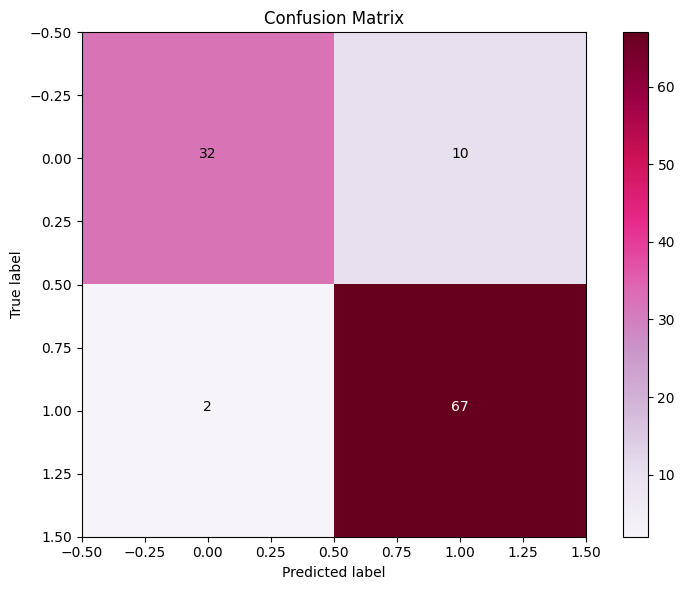

In [160]:
############# plot confusion matrix ############

from matplotlib import pyplot as plt
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, test_preds.round())
# Plot confusion matrix with custom color map

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)  # Set cmap to custom color map
plt.title('Confusion Matrix')
plt.colorbar()

# Adding annotations
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), #'d = integer
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() #improves the layout of plots by preventing overlapping elements such as axis labels, tick labels, and titles
plt.show()
